# Generating Samples 

In [1]:
import torch
from tqdm import tqdm
# Check if CUDA is available and being used
cuda_available = torch.cuda.is_available()
current_device = torch.cuda.current_device() if cuda_available else 'CPU'
device_name = torch.cuda.get_device_name(current_device) if cuda_available else 'CPU'

print(f"CUDA Available: {cuda_available}")
print(f"Current Device: {current_device}")
print(f"Device Name: {device_name}")

CUDA Available: True
Current Device: 0
Device Name: NVIDIA TITAN X (Pascal)


In [ ]:
import json
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from os import path

from data.datasets import postprocess
from models.glow_model.train import get_ds_params
from models.glow_model.model import Glow
from utilities.routes import OUTPUT_DIR

device = torch.device("cuda")
transform =None
# output_folder = 'models/glow_model_/output_additive_cifar10/'
dataset_output = "output_all/"
# model_name = 'glow_model_250.pth'
ds_name = 'gtsrb'  # svhn
model_type = 'glow'

dataset_output_dir = path.join(dataset_output, f"{model_type}_{ds_name}/")

if ds_name == 'cifar10':
    model_name = 'glow_checkpoint_781.pt'

    with open(dataset_output_dir + 'hparams.json') as json_file:  
        hparams = json.load(json_file)

elif ds_name == 'svhn':
    model_name = 'glow_checkpoint_1144.pt'

    with open(dataset_output_dir + 'hparams.json') as json_file:  
        hparams = json.load(json_file)
elif ds_name == 'mnist':
    model_name = 'glow_checkpoint_11244.pt'

    with open(dataset_output_dir + 'hparams.json') as json_file:  
        hparams = json.load(json_file)
elif ds_name == 'imagenet32':
    model_name = 'glow_checkpoint_2001.pt'

    with open(dataset_output_dir + 'hparams.json') as json_file:  
        hparams = json.load(json_file)
elif ds_name == 'celeba':
    model_name = 'glow_checkpoint_2532.pt'

    with open(dataset_output_dir + 'hparams.json') as json_file:  
        hparams = json.load(json_file)
elif ds_name == 'gtsrb':
    model_name = 'glow_checkpoint_416.pt'

    with open(dataset_output_dir + 'hparams.json') as json_file:  
        hparams = json.load(json_file)

image_shape, num_classes, _, test_cifar = get_ds_params(ds_name, hparams['dataroot'], transform, hparams['augment'], hparams['download'])
# image_shape, num_classes, _, test_cifar = get_cifar10(hparams['augment'], hparams['dataroot'], hparams['download'])
# image_shape, num_classes, _, test_svhn = get_svhn(hparams['augment'], hparams['dataroot'], hparams['download'])


model = Glow(image_shape, hparams['hidden_channels'], hparams['K'], hparams['L'], hparams['actnorm_scale'],
             hparams['flow_permutation'], hparams['flow_coupling'], hparams['LU_decomposed'], num_classes,
             hparams['learn_top'], hparams['y_condition'])

model.load_state_dict(torch.load(dataset_output_dir + model_name)['model']) # Load only model part
model.set_actnorm_init()

model = model.to(device)

model = model.eval()

/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/models/glow_model/modules.py:418: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2416.)
  w_init = torch.qr(torch.randn(*w_shape))[0]
/export/home/bmontaze/behrooz_vscode/repos/ood_detections/.venv/lib/python3.10/site-packages/torch/functional.py:1924: UserWarning: torch.lu is deprecated in favor of torch.linalg.lu_factor / torch.linalg.lu_factor_ex and will be removed in a future PyTorch release.
LU, pivots = torch.lu(A, compute_pivots)
should be replaced with
LU, pivots = torch.linalg.lu_factor(A, compute_pivots)
and
LU, pivots, info = torch.lu(A, compute_pivots, get_infos=True)
should be replaced 

In [4]:
# Check what keys are present in the checkpoint
# checkpoint = torch.load(output_folder + model_name, map_location=device)
# print(checkpoint.keys())  


/tmp/ipykernel_3165091/1229722888.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(output_folder + model_name, map_location=device)


dict_keys(['model', 'optimizer'])


In [16]:
# N_BITS = 8
# def postprocess(x):
#     print(x.shape)
#     x = torch.clamp(x, -0.5, 0.5)
#     x += 0.5
#     x = x * 256
#     return torch.clamp(x, 0, 255).byte()

# def postprocess(x):
#     # x = torch.sigmoid(x)  # Ensure values are between 0 and 1
#     x = x * 255  # Rescale to 0-255
#     return x.byte()


In [4]:
def sample(model):
    with torch.no_grad():
        if hparams['y_condition']:
            y = torch.eye(num_classes)
            y = y.repeat(batch_size // num_classes + 1)
            y = y[:4, :].to(device) # number hardcoded in model for now
        else:
            y = None

        images = postprocess(model(y_onehot=y, temperature=1, reverse=True))
        # print(images)
    return images.cpu()

In [76]:
images = sample(model)

grid = make_grid(images[:30], nrow=5).permute(1,2,0)

plt.figure(figsize=(5,5))
plt.imshow(grid)
plt.axis('off')

RuntimeError: normal expects all elements of std >= 0.0

(-0.5, 131.5, 157.5, -0.5)

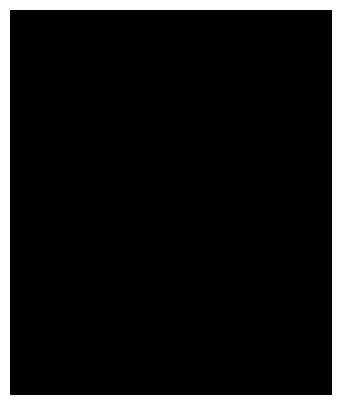

In [10]:
N_BITS = 8

def postprocess(x):
    x = torch.sigmoid(x)  # Normalize between 0 and 1
    x = x * 255  # Rescale to 0-255
    return x.byte()

def sample(model):
    with torch.no_grad():
        if hparams['y_condition']:
            y = torch.eye(num_classes)
            y = y.repeat(batch_size // num_classes + 1)
            y = y[:28, :].to(device)
        else:
            y = None

        z = model(y_onehot=y, temperature=1, reverse=True)  # Generate samples
        images = postprocess(z)

    return images.cpu()

# Sample and visualize
images = sample(model)
grid = make_grid(images[:30], nrow=5).permute(1, 2, 0).squeeze()  # Adjust for grayscale

plt.figure(figsize=(5, 5))
plt.imshow(grid, cmap='gray')  # Ensure the right colormap for grayscale images
plt.axis('off')


# Gradient Features

In [5]:
def gradient_features(model, inputs):
    
    # Set the model to evaluation mode
    model = model.to(device).eval()
    inputs = inputs.to(device)

    # Reset gradients
    model.zero_grad()
    # Enable gradient tracking
    inputs.requires_grad = True

    # Forward pass through the model
    outputs = model(inputs)
    # print(f"{outputs= }")
    
    # If the model outputs a tuple (e.g., logits, auxiliary outputs), extract the logits
    if isinstance(outputs, tuple):
        log_likelihoods = outputs[0]  # Assuming the first element is the relevant output (logits or likelihood)
    else:
        log_likelihoods = outputs  # If it's not a tuple, directly use the output
    # print(f"{log_likelihoods= }")
    # Sum the log-likelihoods to compute the total loss
    loss = torch.sum(log_likelihoods)
    # print(f"{loss= }")
    # Backpropagate to compute gradients
    loss.backward()

    # Calculate layer-wise squared L2 norms of gradients and keep track of the number of features
    features_scalar = []
    features = []
    num_features = []
    for param in model.parameters():
        if param.grad is not None:
            # Layer-wise L2 norm of gradients
            squared_layer_norm = torch.norm(param.grad)**2
            features.append(squared_layer_norm)  # Store the layer-wise norm
            features_scalar.append(squared_layer_norm.item())  # Convert to a scalar and store
            num_features.append(param.grad.numel())  # Store the number of features

    return features, num_features, features_scalar


In [7]:
# for i, param in enumerate(model.parameters()):
#     if param.grad is not None and i <= 2:
#         print(param.grad.shape)
#         print(param.grad)
#     # break


# Fit Guassians to Log_features

In [6]:
from torch.utils.data import DataLoader, Subset
import random
# Randomly select 1000 samples from the fit dataset
# num_samples = 1000
batch_size = 1
# random_indices = random.sample(range(len(test_cifar)), num_samples)

# # Create a subset of the fit_dataset using the random indices
# fit_subset = Subset(test_cifar, random_indices)

# # Create a DataLoader for the subset
# fit_loader = DataLoader(fit_subset, batch_size=batch_size, shuffle=False)

# # Define DataLoader for the test set
fit_loader = DataLoader(test_cifar, batch_size=batch_size, shuffle=False)
# fit_loader = DataLoader(test_svhn, batch_size=batch_size, shuffle=False)

# Get a batch of 5 samples from the test DataLoader
# fit_samples, labels = next(iter(fit_loader))  # Retrieve a batch of inputs and labels
# inputs = inputs.to(device)  # Move inputs to the correct device (GPU or CPU)

# Now you can pass the inputs to your gradient_features function
# features, num_gradients_in_layers, features_scalar = gradient_features(model, fit_samples)


In [5]:
# fit_samples.shape

torch.Size([5, 3, 32, 32])

In [7]:

def fit_gaussians_to_log_features(model, fit_loader, device):
    model.eval()  # Set model to evaluation mode

    # Initialize a list to hold log features for each layer
    # Use a list of tensors initialized with empty tensors to accumulate log features
    all_features = None

    # Loop through batches in the fit dataset
    for inputs, _ in tqdm(fit_loader, desc='Fitting Gaussians to log features'):
        inputs = inputs.to(device)

        # Get the gradient features for the batch
        features, _, _ = gradient_features(model, inputs)

        # Take the log of each feature in the batch
        log_features = [torch.log(f + 1e-10) for f in features]  # Add small value to avoid log(0)

        # If all_features is None, initialize it with the first batch's log features
        if all_features is None:
            all_features = [f.unsqueeze(0) for f in log_features]  # Start a new list of tensors
        else:
            # Concatenate the new log features with existing ones for each layer
            for i in range(len(all_features)):
                all_features[i] = torch.cat((all_features[i], log_features[i].unsqueeze(0)), dim=0)

    # Initialize lists to store Gaussian parameters for each layer
    means = []
    variances = []

    # Iterate over layers to calculate mean and variance
    for layer_features in all_features:
        # Compute mean and variance across batches
        layer_mean = torch.mean(layer_features, dim=0)
        layer_variance = torch.var(layer_features, dim=0)

        # Append as tensors to means and variances
        means.append(layer_mean.detach())  # Detach to avoid gradient tracking
        variances.append(layer_variance.detach())

    return means, variances, all_features

# Fit Gaussians to the log of the gradient features
means, variances, all_features = fit_gaussians_to_log_features(model, fit_loader, device)


Fitting Gaussians to log features: 100%|██████████| 10000/10000 [55:42<00:00,  2.99it/s]


# OOD Score

In [8]:

def gaussian_negative_log_likelihood(log_features, means, variances):
    ood_scores = []

    # Iterate over each layer's features, means, and variances
    for layer_features, mu, sigma2 in zip(log_features, means, variances):
        # Ensure mu and sigma2 are tensors and have the correct shape
        mu = mu.to(layer_features.device)
        sigma2 = sigma2.to(layer_features.device)

        # Reshape sigma2 to allow broadcasting
        if sigma2.dim() == 1:
            sigma2 = sigma2.view(1, -1)  # Shape (1, num_features)

        # Compute the negative log-likelihood for the layer
        epsilon = 1e-10
        nll = 0.5 * torch.sum(((layer_features - mu) ** 2) / (sigma2+epsilon) + torch.log(2 * torch.pi * (sigma2+epsilon)), dim=0)
        ood_scores.append(nll)
        # print(f"{nll= }")

    # Sum over all layers to get the final OOD score for each sample
    # sfeatures = torch.stack(ood_scores)
    # print(f"{sfeatures.shape},\n {sfeatures= }")
    # print(f"{ood_scores= }")
    
    return torch.sum(torch.stack(ood_scores))

def ood_score(model, new_samples, means, variances, device):
    # model.to(device)
    model.eval()  # Set model to evaluation mode

    # Compute the gradient features for the new batch
    features, _, _ = gradient_features(model, new_samples)

    # Take the log of each feature in the batch
    log_features = [torch.log(f + 1e-10) for f in features]  # Add small value to avoid log(0)
    # print(f"{log_features= }")

    # Compute OOD score using Gaussian negative log-likelihood
    ood_scores = gaussian_negative_log_likelihood(log_features, means, variances)

    return ood_scores



In [11]:
# TRain on SVHN and test on CIFAR10

# Randomly select 1000 samples from a dataset
model = model.to(device)
num_samples = min(len(test_cifar), len(test_svhn))
# batch_size = 1


# Create a subset of the test_dataset using the random indices
random_indices = random.sample(range(len(test_cifar)), num_samples)
test_subset = Subset(test_cifar, random_indices)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# test_loader = DataLoader(test_svhn, batch_size=batch_size, shuffle=False)

ood_scores_test_samples = []
for test_samples, _ in tqdm(test_loader, desc="Processing test samples"):
    test_samples = test_samples.to(device)
    # Compute the OOD scores for the test samples
    ood_scores_test_samples.append(ood_score(model, test_samples, means, variances, device))

# Save ood_scores_fit_samples
torch.save(ood_scores_test_samples, f'{dataset_output_dir}/parthially_trained_781_ood_scores_test_samples_1_svhn_on_cifar10.pth')
print("Saved parthially_trained_781_ood_scores_test_samples_1_svhn_on_cifar10.pth")


# Define DataLoader for the fit set
random_indices = random.sample(range(len(test_svhn)), num_samples)
test_subset = Subset(test_svhn, random_indices)
fit_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# fit_loader = DataLoader(test_cifar, batch_size=batch_size, shuffle=False)

ood_scores_fit_samples = []
for fit_samples, _ in tqdm(fit_loader, desc="Processing fit samples"):
    fit_samples = fit_samples.to(device)
    # Compute the OOD scores for the fit samples
    ood_scores_fit_samples.append(ood_score(model, fit_samples, means, variances, device))
# Save ood_scores_fit_samples
torch.save(ood_scores_fit_samples, f'{dataset_output_dir}/partially_trained_1144_ood_scores_fit_samples_1_cifar10_from_test_dataset.pth')
print("Saved partially_trained_1144_ood_scores_fit_samples_1_cifar10_from_test_dataset.pth")


Processing fit samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing fit samples: 100%|██████████| 10000/10000 [1:13:52<00:00,  2.26it/s]


Saved partially_trained_1144_ood_scores_fit_samples_1_cifar10_from_test_dataset.pth


In [8]:
# loader = DataLoader(test_cifar, batch_size=5, shuffle=False)
name = fit_loader.dataset.__str__()
name

'Dataset CIFAR10\n    Number of datapoints: 10000\n    Root location: data/CIFAR10\n    Split: Test\n    StandardTransform\nTransform: Compose(\n               ToTensor()\n               <function preprocess at 0x7fefd4418790>\n           )\nTarget transform: <function one_hot_encode at 0x7fefd44188b0>'

In [9]:
# # TRain on CiFar10 and test on SVHN

# # Randomly select 1000 samples from a dataset
# model = model.to(device)
# num_samples = min(len(test_cifar), len(test_svhn))
# # batch_size = 5


# # Create a subset of the fit_dataset using the random indices
# random_indices = random.sample(range(len(test_svhn)), num_samples)
# test_subset = Subset(test_svhn, random_indices)
# test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# # test_loader = DataLoader(test_svhn, batch_size=batch_size, shuffle=False)

# ood_scores_test_samples = []
# for test_samples, _ in tqdm(test_loader, desc="Calculating ood_scores on test samples"):
#     test_samples = test_samples.to(device)
#     # Compute the OOD scores for the test samples
#     ood_scores_test_samples.append(ood_score(model, test_samples, means, variances, device))

# # Save ood_scores_fit_samples
# torch.save(ood_scores_test_samples, 'output/parthially_trained_ood_scores_test_samples_5_svhn_on_cifar10.pth')
# print("Saved parthially_trained_ood_scores_test_samples_5_svhn_on_cifar10.pth")


# # Define DataLoader for the test set
# random_indices = random.sample(range(len(test_cifar)), num_samples)
# test_subset = Subset(test_cifar, random_indices)
# fit_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# # fit_loader = DataLoader(test_cifar, batch_size=batch_size, shuffle=False)

# ood_scores_fit_samples = []
# for fit_samples, _ in tqdm(fit_loader, desc="Calculating ood_scores on fit samples"):
#     fit_samples = fit_samples.to(device)
#     # Compute the OOD scores for the fit samples
#     ood_scores_fit_samples.append(ood_score(model, fit_samples, means, variances, device))
# # Save ood_scores_fit_samples
# torch.save(ood_scores_fit_samples, 'output/partially_trained_ood_scores_fit_samples_5_cifar10_from_test_dataset.pth')
# print("Saved partially_trained_ood_scores_fit_samples_5_cifar10_from_test_dataset.pth")

# # print(f"{ood_scores_test_samples=}")
# # print(f"{ood_scores_fit_samples=}")


Calculating ood_scores on test samples: 100%|██████████| 2000/2000 [54:25<00:00,  1.63s/it] 


Saved parthially_trained_ood_scores_test_samples_5_svhn_on_cifar10.pth


Calculating ood_scores on fit samples: 100%|██████████| 2000/2000 [54:42<00:00,  1.64s/it] 


Saved partially_trained_ood_scores_fit_samples_1_cifar10_from_test_dataset.pth


# Plot OOD_SCORES

In [ ]:
import re
from collections import defaultdict
from os import listdir, path
from utilities.routes import OUTPUT_DIR

# # Example list of filenames
# file_list = [
#     "ood_scores_fit_samples_b1_cifar10_using_checkpoint_781.pth",
#     "ood_scores_fit_samples_b1_cifar10_using_checkpoint_7810.pth",
#     "ood_scores_test_samples_b1_celeba_on_cifar10_using_checkpoint_781.pth",
#     "ood_scores_test_samples_b1_celeba_on_cifar10_using_checkpoint_7810.pth",
#     "ood_scores_test_samples_b1_imagenet32_on_cifar10_using_checkpoint_781.pth",
#     "ood_scores_test_samples_b1_imagenet32_on_cifar10_using_checkpoint_7810.pth",
#     "ood_scores_test_samples_b1_svhn_on_cifar10_using_checkpoint_781.pth",
#     "ood_scores_test_samples_b1_svhn_on_cifar10_using_checkpoint_7810.pth",
# ]

fit_dataset_name = 'cifar10'  # Name of the dataset used for training
model_type = 'glow'  # Type of model used for training
# List the name of checkpoints for each subfolder
data_path = path.join(OUTPUT_DIR, f"{model_type}_{fit_dataset_name}")

def load_ood_scores(file_path):
    """
    Check if the specified file exists and load the data.
    Args:
    - file_path (str): Path to the file to be loaded.

    Returns:
    - ood_scores (list or None): Loaded data if the file exists, None otherwise.
    """
    if path.exists(file_path):
        print(f"File '{file_path}' is loading...")
        ood_scores = torch.load(file_path)
        return ood_scores
    else:
        print(f"File '{file_path}' not found.")
        return None

# Function to extract checkpoint number
def extract_checkpoint(filename):
    match = re.search(r"checkpoint_(\d+)\.pth", filename)
    return int(match.group(1)) if match else 0

# Sort the file list based on the extracted checkpoint number
sorted_files = sorted(data_path, key=extract_checkpoint)

# Group files by checkpoint number using a dictionary
checkpoint_groups = defaultdict(list)
for filename in sorted_files:
    checkpoint = extract_checkpoint(filename)
    checkpoint_groups[checkpoint].append(filename)

# Convert the dictionary values to a list of lists, each containing files with the same checkpoint
grouped_files = list(checkpoint_groups.values())

# Output grouped filenames
for group in grouped_files:
    print("Checkpoint Group:")
    for filename in group:
        ood_scores_fit_samples = load_ood_scores()
        fit_dir = listdir(filename) if (fit_dir.startswith('ood_scores_fit') and fit_dir.endswith('.pth')) else None
        if fit:

        test_checkpoints = [f for f in listdir(filename) if (f.startswith('ood_scores_test') and f.endswith('.pth'))]
        # print("  ", filename)


Checkpoint Group:
   ood_scores_fit_samples_b1_cifar10_using_checkpoint_781.pth
   ood_scores_test_samples_b1_celeba_on_cifar10_using_checkpoint_781.pth
   ood_scores_test_samples_b1_imagenet32_on_cifar10_using_checkpoint_781.pth
   ood_scores_test_samples_b1_svhn_on_cifar10_using_checkpoint_781.pth
Checkpoint Group:
   ood_scores_fit_samples_b1_cifar10_using_checkpoint_7810.pth
   ood_scores_test_samples_b1_celeba_on_cifar10_using_checkpoint_7810.pth
   ood_scores_test_samples_b1_imagenet32_on_cifar10_using_checkpoint_7810.pth
   ood_scores_test_samples_b1_svhn_on_cifar10_using_checkpoint_7810.pth


File '/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_cifar10/1/ood_scores_fit_samples_b1_cifar10_using_checkpoint_781.pth' is loading...


/tmp/ipykernel_827066/4290629108.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ood_scores = torch.load(file_path)


File '/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_cifar10/1/ood_scores_test_samples_b1_celeba_on_cifar10_using_checkpoint_781.pth' is loading...
File '/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_cifar10/1/ood_scores_test_samples_b1_gtsrb_on_cifar10_using_checkpoint_781.pth' is loading...
File '/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_cifar10/1/ood_scores_test_samples_b1_imagenet32_on_cifar10_using_checkpoint_781.pth' is loading...
File '/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_cifar10/1/ood_scores_test_samples_b1_svhn_on_cifar10_using_checkpoint_781.pth' is loading...


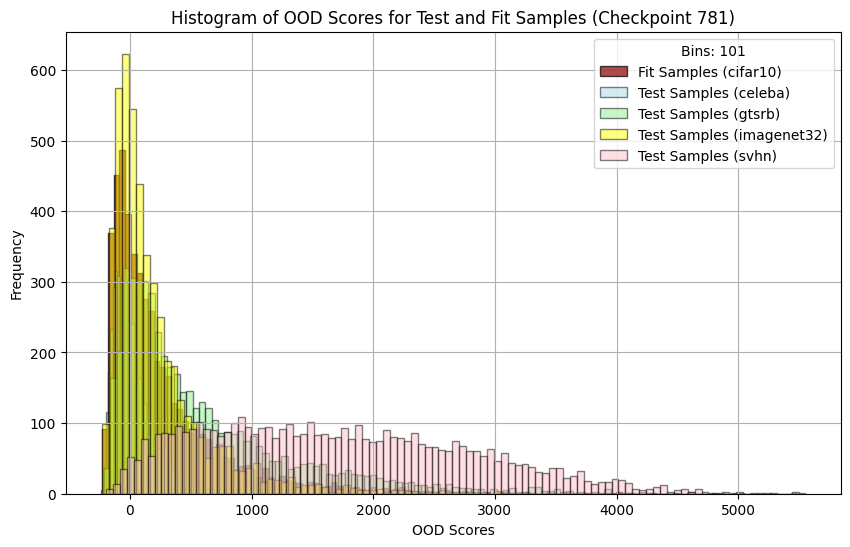

AUROC for celeba against cifar10 (Checkpoint 781): 0.3466
Accuracy using best threshold: 0.5006
Confusion Matrix:
[[  13 4987]
 [   7 4993]]


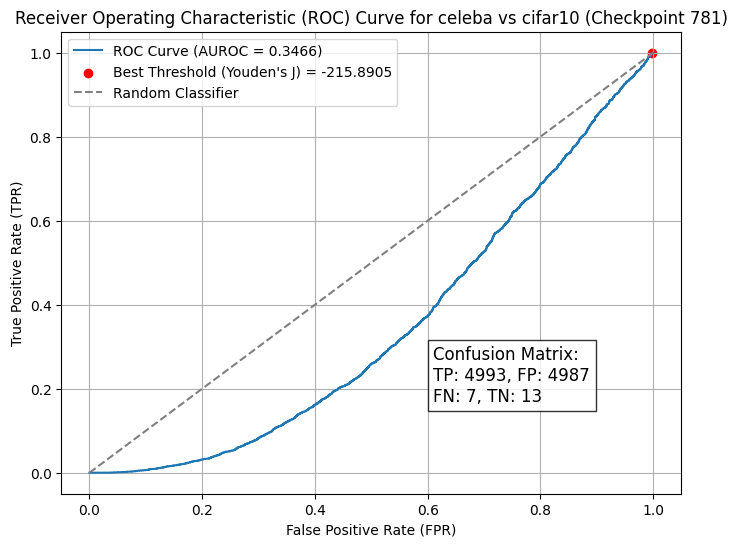

AUROC for gtsrb against cifar10 (Checkpoint 781): 0.6635
Accuracy using best threshold: 0.6136
Confusion Matrix:
[[2506 2494]
 [1370 3630]]


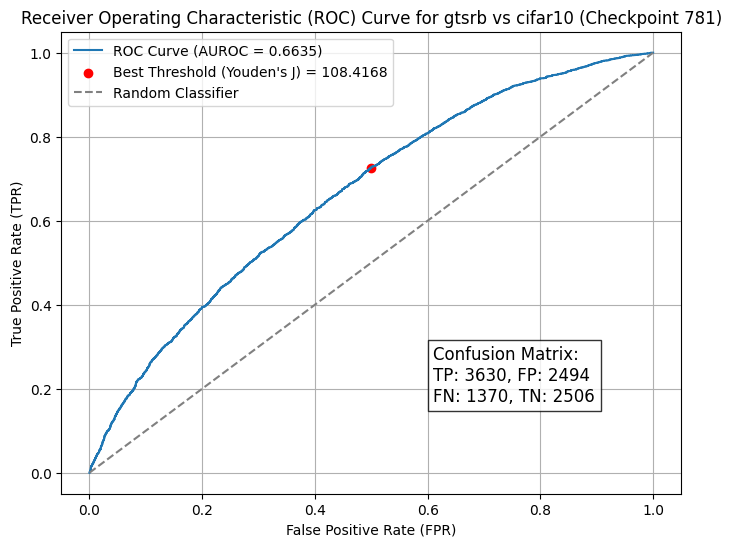

AUROC for imagenet32 against cifar10 (Checkpoint 781): 0.4850
Accuracy using best threshold: 0.5129
Confusion Matrix:
[[1248 3752]
 [1119 3881]]


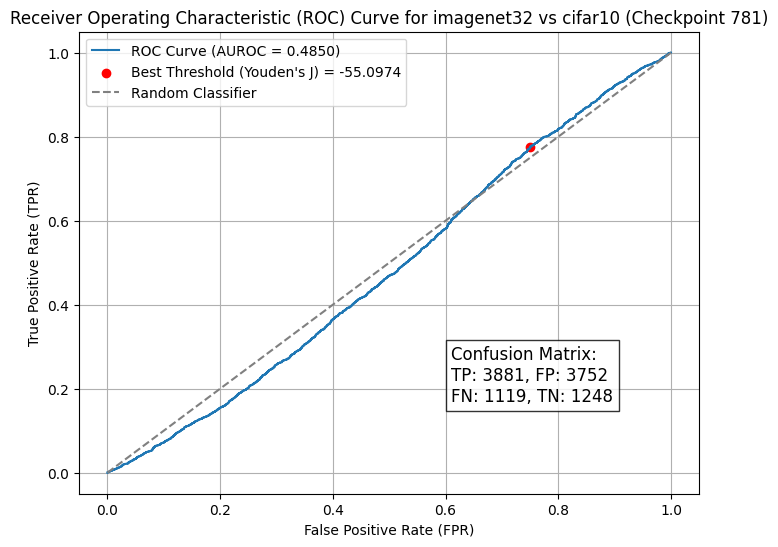

AUROC for svhn against cifar10 (Checkpoint 781): 0.9001
Accuracy using best threshold: 0.8198
Confusion Matrix:
[[4224  776]
 [1026 3974]]


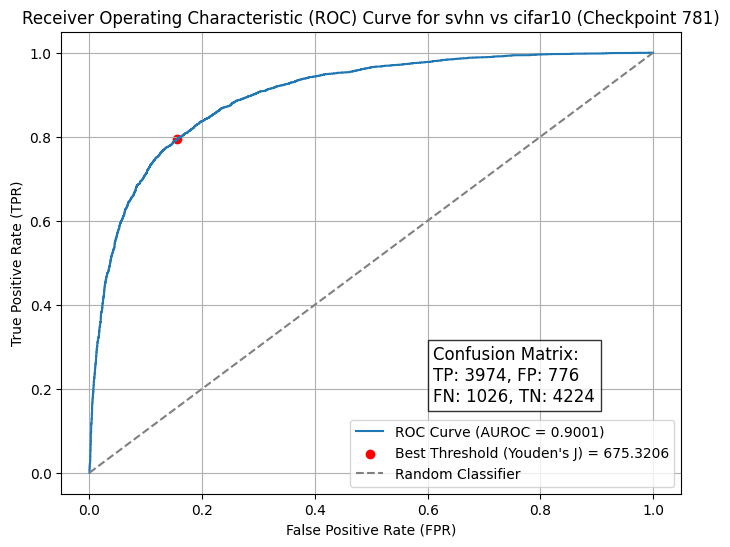

Combined AUROC scores saved to /net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_cifar10/1/plots/combined_auroc_scores.csv
File '/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_cifar10/1/ood_scores_fit_samples_b1_cifar10_using_checkpoint_7810.pth' is loading...


/tmp/ipykernel_827066/4290629108.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ood_scores = torch.load(file_path)


File '/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_cifar10/1/ood_scores_test_samples_b1_celeba_on_cifar10_using_checkpoint_7810.pth' is loading...
File '/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_cifar10/1/ood_scores_test_samples_b1_gtsrb_on_cifar10_using_checkpoint_7810.pth' is loading...
File '/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_cifar10/1/ood_scores_test_samples_b1_imagenet32_on_cifar10_using_checkpoint_7810.pth' is loading...
File '/net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_cifar10/1/ood_scores_test_samples_b1_svhn_on_cifar10_using_checkpoint_7810.pth' is loading...


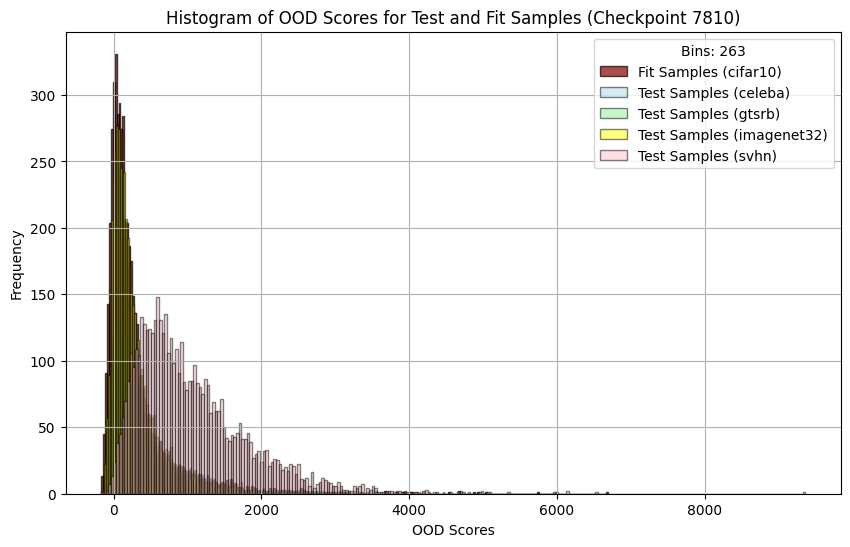

AUROC for celeba against cifar10 (Checkpoint 7810): 0.3799
Accuracy using best threshold: 0.5032
Confusion Matrix:
[[  67 4933]
 [  35 4965]]


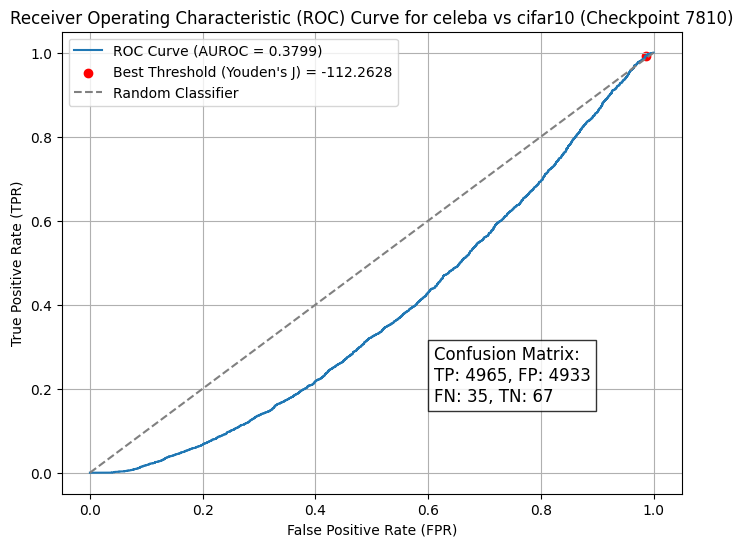

AUROC for gtsrb against cifar10 (Checkpoint 7810): 0.6205
Accuracy using best threshold: 0.5880
Confusion Matrix:
[[3293 1707]
 [2413 2587]]


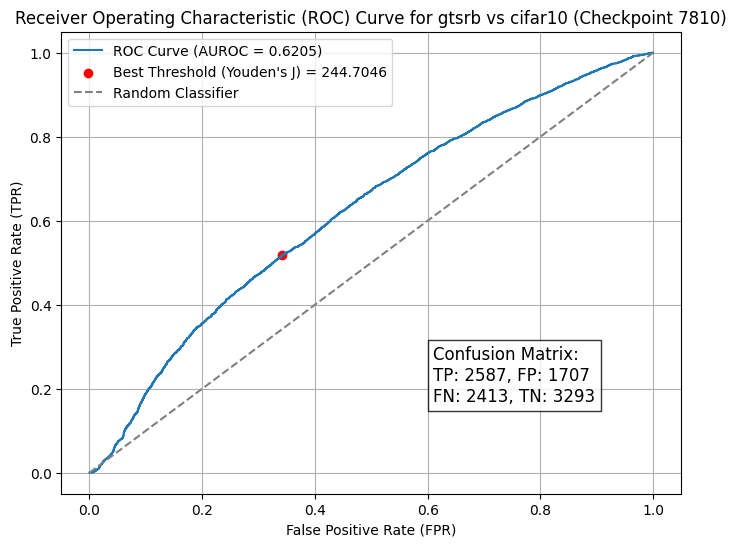

AUROC for imagenet32 against cifar10 (Checkpoint 7810): 0.5473
Accuracy using best threshold: 0.5384
Confusion Matrix:
[[1505 3495]
 [1121 3879]]


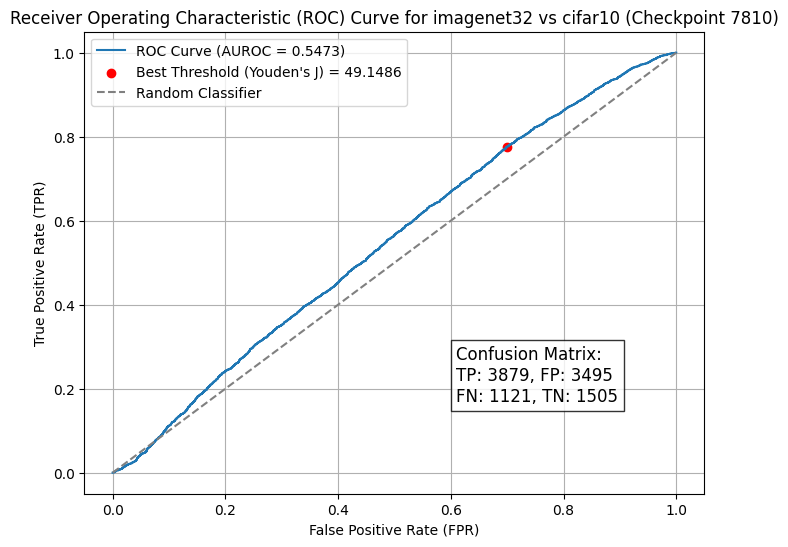

AUROC for svhn against cifar10 (Checkpoint 7810): 0.8708
Accuracy using best threshold: 0.8088
Confusion Matrix:
[[3833 1167]
 [ 745 4255]]


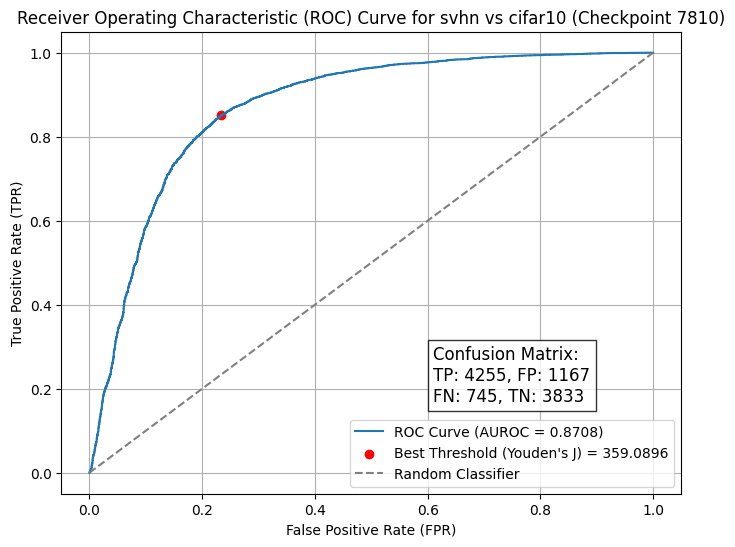

Combined AUROC scores saved to /net/hcihome/storage/bmontaze/behrooz_vscode/repos/ood_detections/output/glow_cifar10/1/plots/combined_auroc_scores.csv


In [4]:
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from os import path, listdir, makedirs
from utilities.routes import OUTPUT_DIR
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve


# Function to extract checkpoint, dataset name, and batch size from the filename
def parse_filename(filename):
    # Extract checkpoint number
    checkpoint_match = re.search(r"checkpoint_(\d+)\.pth", filename)
    checkpoint = int(checkpoint_match.group(1)) if checkpoint_match else None

    # Extract dataset names and batch size for fit samples
    fit_match = re.search(r"ood_scores_fit_samples_b(\d+)_([a-zA-Z0-9]+)_using_checkpoint", filename)
    test_match = re.search(r"ood_scores_test_samples_b(\d+)_([a-zA-Z0-9]+)_on_([a-zA-Z0-9]+)_using_checkpoint", filename)

    if fit_match:
        batch_size = int(fit_match.group(1))
        dataset_name = fit_match.group(2)  
        return 'fit', batch_size, dataset_name, checkpoint
    
    elif test_match:
        batch_size = int(test_match.group(1))
        test_dataset_name = test_match.group(2)  
        fit_dataset_name = test_match.group(3)   
        return 'test', batch_size, test_dataset_name, fit_dataset_name, checkpoint
    
    return None

# Function to group files by checkpoint
def group_files_by_checkpoint(file_path):
    grouped_files = defaultdict(lambda: {'fit': None, 'tests': []})
    
    file_list = [f for f in listdir(file_path) if (f.startswith('ood_scores') and f.endswith('.pth'))]
    for filename in file_list:
        parsed = parse_filename(filename)
        if parsed:
            if parsed[0] == 'fit':  # It's a fit file
                checkpoint = parsed[3]
                grouped_files[checkpoint]['fit'] = filename
            elif parsed[0] == 'test':  # It's a test file
                checkpoint = parsed[4]
                grouped_files[checkpoint]['tests'].append(filename)
    
    # Filter out incomplete groups (i.e., those without both fit and tests)
    return {k: v for k, v in grouped_files.items() if v['fit'] and len(v['tests']) == 4}

# Function to read OOD scores from a file
def read_ood_scores(file_name):
    file_path = path.join(data_path, file_name)
    if path.exists(file_path):
        print(f"File '{file_path}' is loading...")
        ood_scores = torch.load(file_path)
        return torch.cat([score.unsqueeze(0) for score in ood_scores], dim=0).cpu().detach().numpy()
    else:
        print(f"File '{file_path}' not found.")
        return None


# Function to plot histograms for fit and test scores
def plot_histogram(fit_scores, test_scores_dict, fit_dataset_name, checkpoint, output_dir):
    # Calculate optimal bins
    test_scores_list = [scores for scores in test_scores_dict.values()]
    bins = best_bin_size(fit_scores, test_scores_list)
    
    plt.figure(figsize=(10, 6))
    
    # Define a more distinctive list of colors for the datasets
    colors = ['#ADD8E6', '#90EE90', '#FFFF00', '#FFC0CB']  # Light blue, light green, yellow, pink
    color_cycle = iter(colors)  # Create an iterator to cycle through the colors
    
    # Plot histogram for fit samples
    plt.hist(fit_scores, bins=bins, alpha=0.7, label=f'Fit Samples ({fit_dataset_name})', color='#8B0000', edgecolor='black')
    
    # Plot histogram for each test dataset with distinct colors
    for test_name, scores in test_scores_dict.items():
        plt.hist(scores, bins=bins, alpha=0.5, label=f'Test Samples ({test_name})', color=next(color_cycle), edgecolor='black')
    
    # Add labels and title
    plt.xlabel('OOD Scores')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of OOD Scores for Test and Fit Samples (Checkpoint {checkpoint})')
    plt.legend(title=f'Bins: {bins}')
    plt.grid(True)

    # Save the plot
    plot_filename = f"histogram_{fit_dataset_name}_checkpoint_{checkpoint}.png"
    plt.savefig(path.join(output_dir, plot_filename))
    
    # Show the plot
    plt.show()

# Function to calculate the optimal bin size using the Freedman-Diaconis rule
def best_bin_size(fit_scores, test_scores_list):
    all_scores = np.concatenate([fit_scores, *test_scores_list])
    q25, q75 = np.percentile(all_scores, [25, 75])
    bin_width = 2 * (q75 - q25) * len(all_scores) ** (-1/3)
    bins = int((all_scores.max() - all_scores.min()) / bin_width)
    return max(bins, 10)  # Ensure a minimum of 10 bins

# Main function to process files, read scores, and plot
def process_and_plot(file_path):
    # Group files by checkpoint
    grouped_files = group_files_by_checkpoint(file_path)
    
    for checkpoint, files in grouped_files.items():
        # Read fit scores
        fit_filename = files['fit']
        fit_info = parse_filename(fit_filename)
        fit_dataset_name = fit_info[2]
        fit_scores = read_ood_scores(fit_filename)

        # Read test scores for each test dataset in this checkpoint group
        test_scores_dict = {}
        # test_scores_list = []
        for test_filename in files['tests']:
            test_info = parse_filename(test_filename)
            test_dataset_name = test_info[2]
            test_scores = read_ood_scores(test_filename)
            test_scores_dict[test_dataset_name] = test_scores
            # test_scores_list.append(test_scores)


        # Plot histograms
        plot_histogram(fit_scores, test_scores_dict, fit_dataset_name, checkpoint, output_plot_dir)

        # Plot AUROC
        auroc_df = plot_auroc(fit_scores, test_scores_dict, fit_dataset_name, checkpoint, output_plot_dir)
        save_auroc_csv(auroc_df, output_plot_dir)

def plot_auroc(fit_scores, test_scores_dict, fit_dataset_name, checkpoint, output_dir):
    """Calculate and plot AUROC for fit against each test dataset, returning a DataFrame with AUROC scores."""
    
    # Define the column name based on fit_dataset_name and checkpoint
    column_name = f"{fit_dataset_name}_checkpoint_{checkpoint}"
    
    # Dictionary to store current checkpoint AUROC scores
    auroc_scores = {}

    for test_name, test_scores in test_scores_dict.items():
        # Create labels: 0 for fit samples (in-distribution), 1 for test samples (out-of-distribution)
        labels_fit = np.zeros_like(fit_scores)  # 0 for in-distribution
        labels_test = np.ones_like(test_scores)  # 1 for out-of-distribution

        # Concatenate scores and labels
        all_scores = np.concatenate([fit_scores, test_scores])
        all_labels = np.concatenate([labels_fit, labels_test])

        # Step 1: Compute ROC curve and AUROC
        fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
        auroc = roc_auc_score(all_labels, all_scores)
        
        # Store the AUROC score in the dictionary
        auroc_scores[test_name] = auroc
        
        print(f"AUROC for {test_name} against {fit_dataset_name} (Checkpoint {checkpoint}): {auroc:.4f}")

        # Step 2: Compute Youden's J statistic to find the best threshold
        J_scores = tpr - fpr  # Youden's J statistic
        best_threshold_index = np.argmax(J_scores)  # Index of the best threshold
        best_threshold = thresholds[best_threshold_index]

        # Step 3: Evaluate using the best threshold
        predictions = (all_scores > best_threshold).astype(int)  # Apply the best threshold
        accuracy = accuracy_score(all_labels, predictions)
        conf_matrix = confusion_matrix(all_labels, predictions)
        conf_matrix_text = f"Confusion Matrix:\nTP: {conf_matrix[1, 1]}, FP: {conf_matrix[0, 1]}\nFN: {conf_matrix[1, 0]}, TN: {conf_matrix[0, 0]}"

        print(f"Accuracy using best threshold: {accuracy:.4f}")
        print(f"Confusion Matrix:\n{conf_matrix}")

        # Step 4: Plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.text(0.6, 0.2, conf_matrix_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8), transform=plt.gca().transAxes)
        plt.plot(fpr, tpr, label=f"ROC Curve (AUROC = {auroc:.4f})")
        plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index], color='red', label=f"Best Threshold (Youden's J) = {best_threshold:.4f}")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.title(f"Receiver Operating Characteristic (ROC) Curve for {test_name} vs {fit_dataset_name} (Checkpoint {checkpoint})")
        plt.legend()
        plt.grid(True)
        
        # Save the plot
        plot_filename = f'roc_curve_{fit_dataset_name}_{test_name}_checkpoint_{checkpoint}.png'
        plt.savefig(path.join(output_dir, plot_filename))
        plt.show()
    
    # Convert auroc_scores to a DataFrame with one column for the current checkpoint
    checkpoint_df = pd.DataFrame.from_dict(auroc_scores, orient='index', columns=[column_name])

    return checkpoint_df


def save_auroc_csv(auroc_df, output_dir):
    """Save the accumulated AUROC DataFrame to CSV without overwriting previous data."""
    auroc_csv_filename = 'combined_auroc_scores.csv'
    output_path = path.join(output_dir, auroc_csv_filename)
    
    # If the file exists, load the existing data and concatenate
    if path.exists(output_path):
        existing_df = pd.read_csv(output_path, index_col=0)
        auroc_df = pd.concat([existing_df, auroc_df], axis=1)
    
    # Save the combined DataFrame
    auroc_df.to_csv(output_path)
    print(f"Combined AUROC scores saved to {output_path}")

fit_dataset_name = 'cifar10'  # Name of the dataset used for training
model_type = 'glow'  # Type of model used for training
ood_batch_size = "1"  # Checkpoint number for the model
# List the name of checkpoints for each subfolder
data_path = path.join(OUTPUT_DIR, f"{model_type}_{fit_dataset_name}")
data_path = path.join(data_path, ood_batch_size)
output_plot_dir = path.join(data_path, "plots")

# Create output directory if it doesn't exist
makedirs(output_plot_dir, exist_ok=True)

# Call the main function to process and plot
process_and_plot(data_path)


In [ ]:
from os import listdir, path
from utilities.routes import OUTPUT_DIR
def load_ood_scores(file_path):
    """
    Check if the specified file exists and load the data.
    Args:
    - file_path (str): Path to the file to be loaded.

    Returns:
    - ood_scores (list or None): Loaded data if the file exists, None otherwise.
    """
    if path.exists(file_path):
        print(f"File '{file_path}' is loading...")
        ood_scores = torch.load(file_path)
        return ood_scores
    else:
        print(f"File '{file_path}' not found.")
        return None
    


fit_dataset_name = 'cifar10'  # Name of the dataset used for training
model_type = 'glow'  # Type of model used for training
# List the name of checkpoints for each subfolder
data_path = path.join(OUTPUT_DIR, f"{model_type}_{fit_dataset_name}")
fit_checkpoints = [f for f in listdir(data_path) if (f.startswith('ood_scores_fit') and f.endswith('.pth'))]
test_checkpoints = [f for f in listdir(data_path) if (f.startswith('ood_scores_test') and f.endswith('.pth'))]

# Load ood_scores_fit_samples
ood_scores_fit_samples = load_ood_scores() # ood_scores_fit_samples_cifar10_from_test_dataset  ood_scores_fit_samples_svhn_from_test_dataset
# Load ood_scores_test_samples
ood_scores_test_samples = load_ood_scores(f'{dataset_output_dir}/parthially_trained_286000_ood_scores_test_samples_1_cifar10_on_svhn.pth') # ood_scores_test_samples_svhn_on_cifar10 ood_scores_test_samples_cifar10_on_svhn


File 'output/partially_trained_286000_ood_scores_fit_samples_1_svhn_from_test_dataset.pth' is loading...


/tmp/ipykernel_640242/733058708.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ood_scores = torch.load(file_path)


File 'output/parthially_trained_286000_ood_scores_test_samples_1_cifar10_on_svhn.pth' is loading...


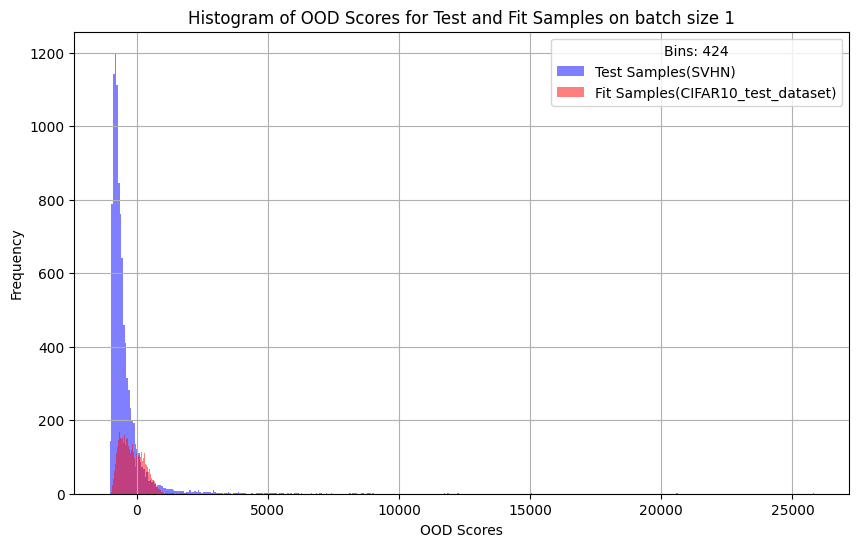

In [12]:

# Convert the list of OOD score tensors into a single tensor (unsqueeze to make 1D if necessary)
ood_scores_test_sample = torch.cat([score.unsqueeze(0) for score in ood_scores_test_samples], dim=0).cpu().detach().numpy()
ood_scores_fit_sample = torch.cat([score.unsqueeze(0) for score in ood_scores_fit_samples], dim=0).cpu().detach().numpy()

# Determine the number of bins using the Freedman-Diaconis rule for better clarity
q25, q75 = np.percentile(np.concatenate([ood_scores_test_sample, ood_scores_fit_sample]), [25, 75])
bin_width = 2 * (q75 - q25) * len(ood_scores_test_sample) ** (-1/3)
bins = int((ood_scores_test_sample.max() - ood_scores_test_sample.min()) / bin_width)

# if bins < 10:
#     bins = 10  # Set a minimum number of bins for better clarity

# Plot the histograms of both OOD scores with fixed-size bins
plt.figure(figsize=(10, 6))

# Plot for test samples
plt.hist(ood_scores_test_sample, bins=bins, alpha=0.5, label=f'Test Samples(SVHN)', color='blue')

# Plot for fit samples
plt.hist(ood_scores_fit_sample, bins=bins, alpha=0.5, label='Fit Samples(CIFAR10_test_dataset)', color='red')

# Add labels and title
plt.xlabel('OOD Scores')
plt.ylabel('Frequency')
plt.title('Histogram of OOD Scores for Test and Fit Samples on batch size 1')

# Add legend
plt.legend(title=f'Bins: {bins}')
plt.grid(True)
# Save the plot
plt.savefig(f'{dataset_output_dir}/(Partially_trained_781)histogram_cifar10_svhn_10k_1s_test_ds.png')
# Show the plot
plt.show()



In [22]:
bin_width

10403.191534178794

AUROC: 0.2476
Best threshold based on Youden's J statistic: 961.3206
Accuracy using best threshold: 0.5127
Confusion Matrix:
[[9907   93]
 [9653  347]]


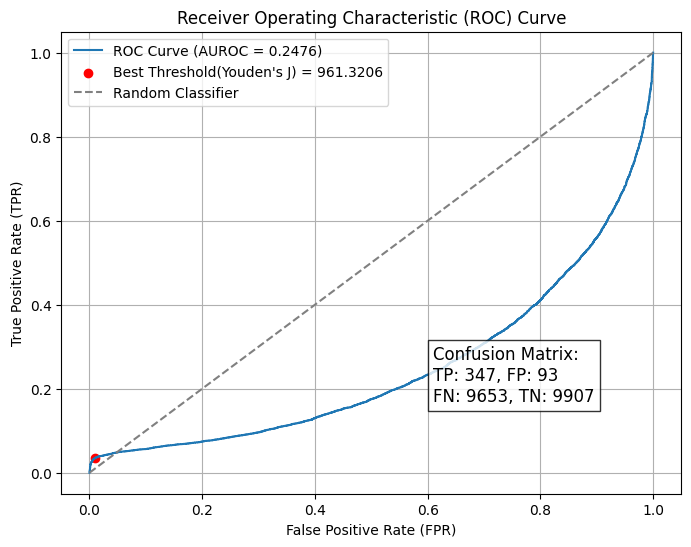

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

# Labels: 0 for fit_samples (in-distribution), 1 for test_samples (out-of-distribution)
labels_fit = np.zeros_like(ood_scores_fit_sample)  # 0 for in-distribution
labels_test = np.ones_like(ood_scores_test_sample)  # 1 for out-of-distribution

# Concatenate scores and labels
all_scores = np.concatenate([ood_scores_fit_sample, ood_scores_test_sample])
all_labels = np.concatenate([labels_fit, labels_test])

# Step 1: Compute ROC curve and AUROC
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
auroc = roc_auc_score(all_labels, all_scores)
print(f"AUROC: {auroc:.4f}")

# Step 2: Compute Youden's J statistic to find the best threshold
J_scores = tpr - fpr  # Youden's J statistic
best_threshold_index = np.argmax(J_scores)  # Index of the best threshold
best_threshold = thresholds[best_threshold_index]

print(f"Best threshold based on Youden's J statistic: {best_threshold:.4f}")

# Step 3: Evaluate using the best threshold
predictions = (all_scores > best_threshold).astype(int)  # Apply the best threshold
accuracy = accuracy_score(all_labels, predictions)
conf_matrix = confusion_matrix(all_labels, predictions)
conf_matrix_text = f"Confusion Matrix:\nTP: {conf_matrix[1, 1]}, FP: {conf_matrix[0, 1]}\nFN: {conf_matrix[1, 0]}, TN: {conf_matrix[0, 0]}"

print(f"Accuracy using best threshold: {accuracy:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.text(0.6, 0.2, conf_matrix_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8), transform=plt.gca().transAxes)
plt.plot(fpr, tpr, label=f"ROC Curve (AUROC = {auroc:.4f})")
plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index], color='red', label=f"Best Threshold(Youden's J) = {best_threshold:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid(True)
plt.savefig(f'{dataset_output_dir}/(Partially_trained_781)auroc_cifar10_svhn_10k_1s_test_ds.png')
plt.show()

# NOTE: As the number of samples in cifar10 is only 10000, compared to 26032 in SVHN, the AUROC of cifar10 is not very close to the paper,
#  but the one from SVHN is better from the paper. training on CIFAR10 and testing on SVHN uses the same number for both training and fitting.
# However, for SVHN we train on 26032 and test on 10000, which results to better AUROC than the paper. 
# NOTE: we have to increase the number of samples in train dataset or use a f=very small number of fit samples to get a better AUROC

In [18]:
print(f"{thresholds = }")
print(f"{fpr = }")
print(f"{tpr = }")
print(f"{predictions = }")

thresholds = array([          inf, 6.0478600e+11, 6.0478593e+11, 6.0478587e+11],
      dtype=float32)
fpr = array([0.00e+00, 5.00e-04, 1.25e-02, 1.00e+00])
tpr = array([0.000e+00, 5.000e-04, 9.745e-01, 1.000e+00])
predictions = array([0, 0, 0, ..., 0, 0, 0])


# Plots of Means and Variances

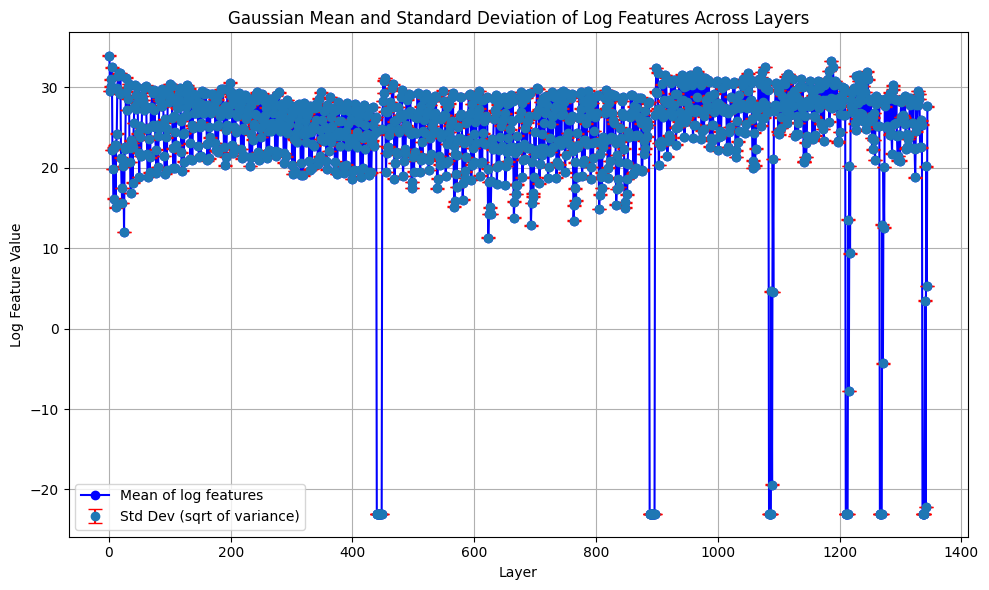

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gaussians(means, variances, layer_labels=None):
    """
    Plots the Gaussian mean and variance for each layer's log features.
    
    Args:
    - means: List of mean values for each layer.
    - variances: List of variance values for each layer.
    - layer_labels: List of layer labels or indices. Optional.
    """
    num_layers = len(means)
    layers = np.arange(1, num_layers + 1) if layer_labels is None else layer_labels

    # Convert variances to standard deviations
    std_devs = [np.sqrt(var) for var in variances]

    # Plot the means and standard deviations
    plt.figure(figsize=(10, 6))

    # Plot the mean of log features for each layer
    plt.plot(layers, means, label='Mean of log features', color='b', marker='o')

    # Plot the variance (as standard deviation) of log features for each layer
    plt.errorbar(layers, means, yerr=std_devs, fmt='o', ecolor='r', capsize=5, label='Std Dev (sqrt of variance)')

    # Labels and title
    plt.xlabel("Layer")
    plt.ylabel("Log Feature Value")
    plt.title("Gaussian Mean and Standard Deviation of Log Features Across Layers")
    plt.legend()

    # Optionally, set layer indices as x-ticks
    if layer_labels:
        plt.xticks(layers, layer_labels, rotation=45)

    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
# Assume 'means' and 'variances' are already computed from the previous steps
plot_gaussians(means, variances)


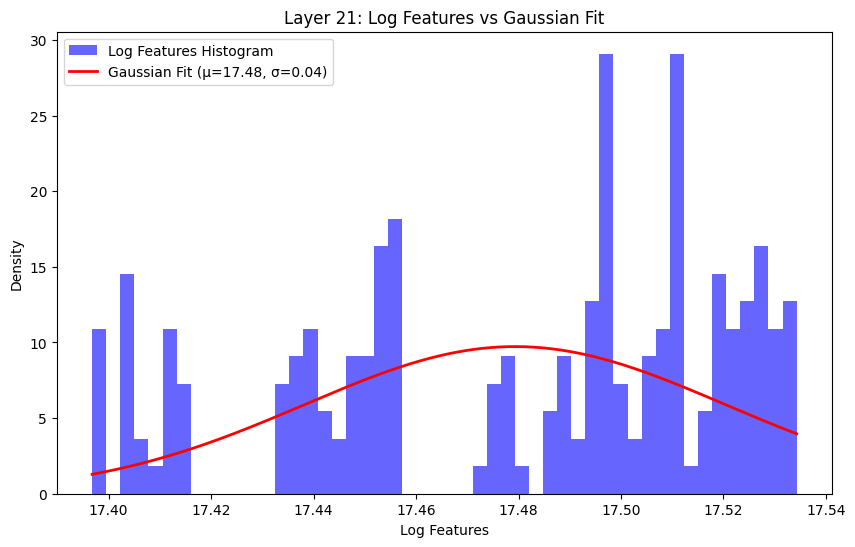

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

def plot_gaussian_with_histogram(log_features, means, variances, layer_idx):
    """
    Plot histogram of log features with the fitted Gaussian overlaid.
    
    Parameters:
        log_features (Tensor): Log-transformed features for a specific layer.
        means (list): Mean of the Gaussian for each layer.
        variances (list): Variance of the Gaussian for each layer.
        layer_idx (int): Index of the layer to plot.
    """
    log_features_np = log_features.cpu().numpy().flatten()  # Convert to NumPy array and flatten for plotting
    
    # Compute the Gaussian curve based on the mean and variance
    mu = means[layer_idx]
    sigma = np.sqrt(variances[layer_idx])
    
    # Define the range for plotting the Gaussian curve
    x_min = np.min(log_features_np)
    x_max = np.max(log_features_np)
    x_range = np.linspace(x_min, x_max, 1000)
    gaussian_curve = norm.pdf(x_range, mu, sigma)

    # Create the histogram for the log features
    plt.figure(figsize=(10, 6))
    plt.hist(log_features_np, bins=50, density=True, alpha=0.6, color='blue', label='Log Features Histogram')
    
    # Plot the Gaussian curve
    plt.plot(x_range, gaussian_curve, 'r-', label=f'Gaussian Fit (μ={mu:.2f}, σ={sigma:.2f})', lw=2)

    # Labels and title
    plt.xlabel('Log Features')
    plt.ylabel('Density')
    plt.title(f'Layer {layer_idx + 1}: Log Features vs Gaussian Fit')
    plt.legend()
    
    # Show the plot
    plt.show()

# Example usage (assuming log_features, means, and variances are already computed):

# Layer index to plot (e.g., 0 for the first layer)
layer_idx = 20

# Plot the histogram and Gaussian fit for layer 0
plot_gaussian_with_histogram(all_features[layer_idx], means, variances, layer_idx)


In [57]:
all_features[20]

tensor([17.3973, 17.3971, 17.3968, 17.3970, 17.3973, 17.3972, 17.4048, 17.4044,
        17.4038, 17.4045, 17.4045, 17.4038, 17.4040, 17.4029, 17.4063, 17.4061,
        17.4093, 17.4115, 17.4132, 17.4127, 17.4128, 17.4126, 17.4141, 17.4129,
        17.4135, 17.4140, 17.4147, 17.4344, 17.4334, 17.4333, 17.4341, 17.4354,
        17.4368, 17.4369, 17.4367, 17.4366, 17.4389, 17.4395, 17.4393, 17.4402,
        17.4417, 17.4409, 17.4399, 17.4407, 17.4408, 17.4439, 17.4478, 17.4462,
        17.4465, 17.4469, 17.4484, 17.4501, 17.4501, 17.4511, 17.4516, 17.4528,
        17.4546, 17.4512, 17.4481, 17.4540, 17.4541, 17.4542, 17.4540, 17.4542,
        17.4539, 17.4544, 17.4545, 17.4560, 17.4562, 17.4562, 17.4561, 17.4561,
        17.4552, 17.4558, 17.4559, 17.4560, 17.4728, 17.4749, 17.4749, 17.4748,
        17.4746, 17.4767, 17.4767, 17.4768, 17.4772, 17.4775, 17.4801, 17.4863,
        17.4866, 17.4868, 17.4897, 17.4896, 17.4898, 17.4894, 17.4889, 17.4944,
        17.4927, 17.4926, 17.4932, 17.49

# Ploting

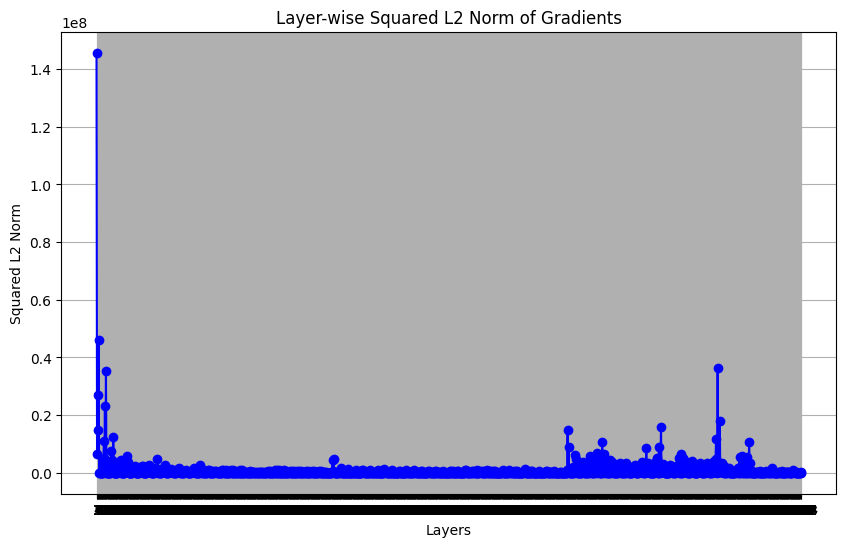

In [9]:
import matplotlib.pyplot as plt

# Assuming `features` is the list or tensor of layer-wise L2 norms returned by gradient_features function
def plot_layer_wise_features(features):
    # Number of layers (same as the number of features)
    num_layers = len(features)

    # Create a range for the layers
    layers = range(1, num_layers + 1)

    # Plotting the features
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.plot(layers, features, marker='o', linestyle='-', color='b')  # Line plot with markers
    plt.title('Layer-wise Squared L2 Norm of Gradients')
    plt.xlabel('Layers')
    plt.ylabel('Squared L2 Norm')
    plt.xticks(layers)  # Set x-axis ticks to be the layer numbers
    plt.grid(True)  # Add a grid for easier visualization
    plt.show()  # Display the plot

# Plot the layer-wise features
plot_layer_wise_features(features_scalar)  


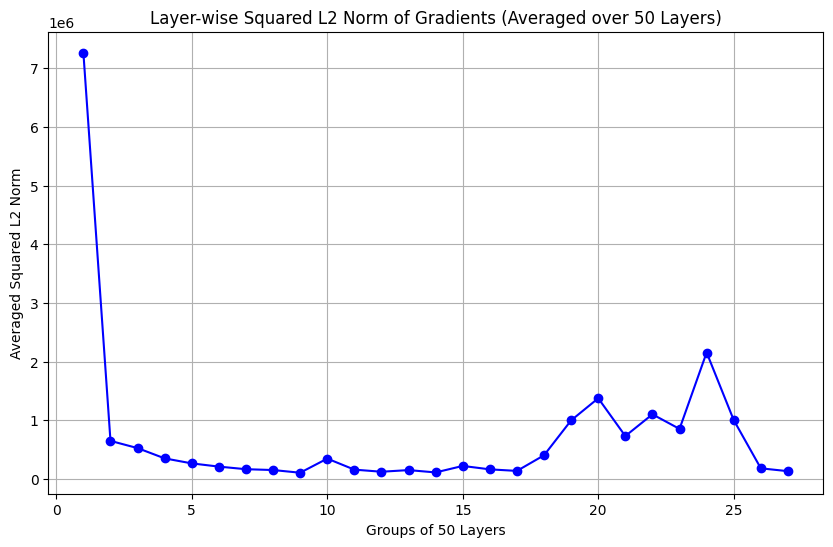

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_layer_wise_features(features, group_size=50):
    # Group layers by averaging every `group_size` layers
    num_layers = len(features)
    grouped_features = [
        np.mean(features[i:i + group_size]) for i in range(0, num_layers, group_size)
    ]
    
    # Corresponding layer indices
    grouped_layers = range(1, len(grouped_features) + 1)

    # Plotting the features
    plt.figure(figsize=(10, 6))
    plt.plot(grouped_layers, grouped_features, marker='o', linestyle='-', color='b')
    plt.title(f'Layer-wise Squared L2 Norm of Gradients (Averaged over {group_size} Layers)')
    plt.xlabel(f'Groups of {group_size} Layers')
    plt.ylabel('Averaged Squared L2 Norm')
    plt.grid(True)
    plt.show()

 # Average every 50 layers
plot_layer_wise_features(features_scalar, group_size=50) 


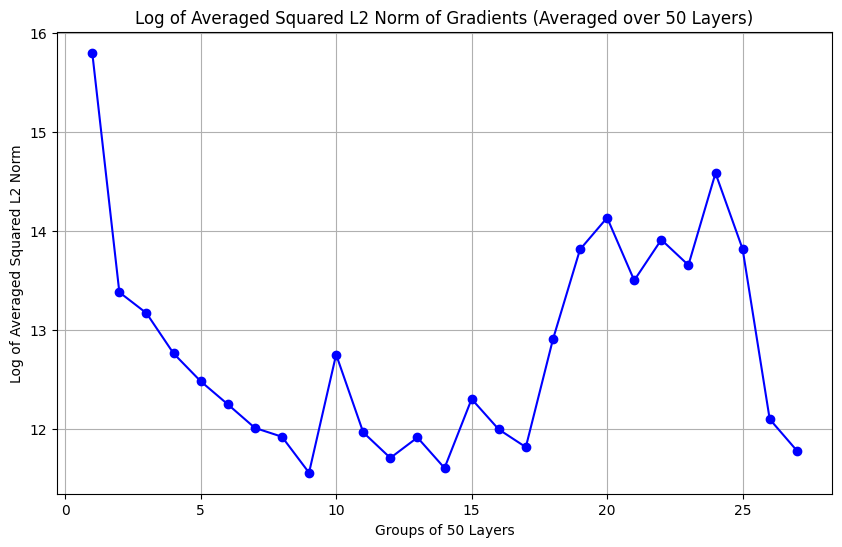

In [11]:
def plot_layer_wise_features_log_avg(features, group_size=50):
    # Group layers by averaging every `group_size` layers
    num_layers = len(features)
    grouped_features = [
        np.mean(features[i:i + group_size]) for i in range(0, num_layers, group_size)
    ]
    
    # Apply logarithmic scaling
    log_grouped_features = np.log1p(grouped_features)  # Using log1p for numerical stability (log(1+x))

    # Corresponding layer indices
    grouped_layers = range(1, len(log_grouped_features) + 1)

    # Plotting with logarithmic scaling on y-axis
    plt.figure(figsize=(10, 6))
    plt.plot(grouped_layers, log_grouped_features, marker='o', linestyle='-', color='b')
    plt.title(f'Log of Averaged Squared L2 Norm of Gradients (Averaged over {group_size} Layers)')
    plt.xlabel(f'Groups of {group_size} Layers')
    plt.ylabel('Log of Averaged Squared L2 Norm')
    plt.grid(True)
    plt.show()

# Example usage
plot_layer_wise_features_log_avg(features_scalar, group_size=50)


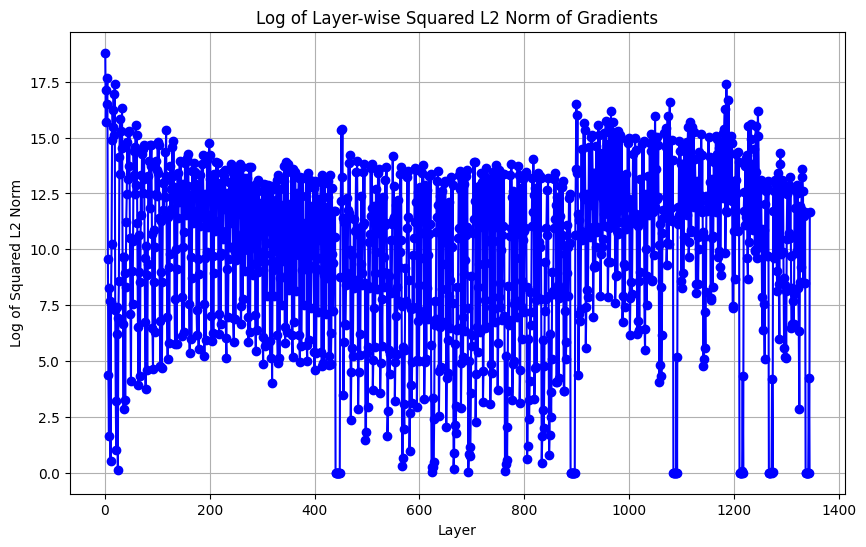

In [12]:
def plot_layer_wise_features_log(features):
    # Apply logarithmic scaling directly to features
    log_features = np.log1p(features)  # Using log1p for numerical stability

    # Layer indices
    layers = range(1, len(log_features) + 1)

    # Plotting the features
    plt.figure(figsize=(10, 6))
    plt.plot(layers, log_features, marker='o', linestyle='-', color='b')
    plt.title(f'Log of Layer-wise Squared L2 Norm of Gradients')
    plt.xlabel('Layer')
    plt.ylabel('Log of Squared L2 Norm')
    plt.grid(True)
    plt.show()

# Example usage
plot_layer_wise_features_log(features_scalar)



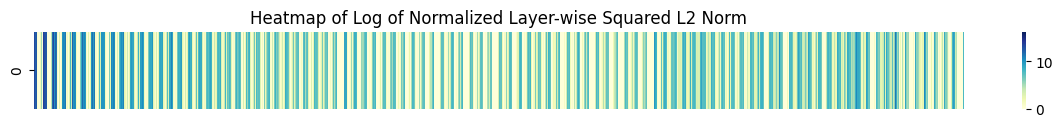

In [13]:
import seaborn as sns

def plot_layer_wise_heatmap_log(features, num_gradients_in_layers):
    # Normalize the features based on num_gradients_in_layers
    normalized_features = [f / n for f, n in zip(features, num_gradients_in_layers)]
    
    # Apply logarithmic scaling
    log_features = np.log1p(normalized_features)  # Using log1p for numerical stability
 
    # Convert features to 2D array for heatmap (assuming 1D)
    heatmap_data = np.array(log_features).reshape(1, -1)

    # Plotting heatmap
    plt.figure(figsize=(15, 1))
    sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, xticklabels=False)
    plt.title(f'Heatmap of Log of Normalized Layer-wise Squared L2 Norm')
    plt.show()

# Example usage
plot_layer_wise_heatmap_log(features_scalar, num_gradients_in_layers)

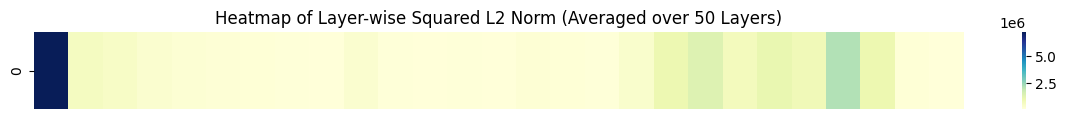

In [14]:
def plot_layer_wise_heatmap(features, group_size=50):
    # Group layers by averaging every `group_size` layers
    num_layers = len(features)
    grouped_features = [
        np.mean(features[i:i + group_size]) for i in range(0, num_layers, group_size)
    ]
    
    # Convert features to 2D array for heatmap (assuming 1D)
    heatmap_data = np.array(grouped_features).reshape(1, -1)

    # Plotting heatmap
    plt.figure(figsize=(15, 1))
    sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, xticklabels=False)
    plt.title(f'Heatmap of Layer-wise Squared L2 Norm (Averaged over {group_size} Layers)')
    plt.show()

# Example usage
plot_layer_wise_heatmap(features_scalar, group_size=50)


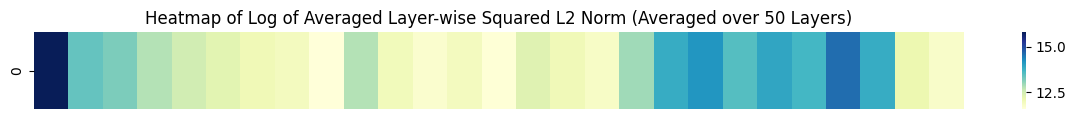

In [15]:
def plot_layer_wise_heatmap_log(features, group_size=50):
    # Group layers by averaging every `group_size` layers
    num_layers = len(features)
    grouped_features = [
        np.mean(features[i:i + group_size]) for i in range(0, num_layers, group_size)
    ]
    
    # Apply logarithmic scaling
    log_grouped_features = np.log1p(grouped_features)  # Using log1p for numerical stability

    # Convert features to 2D array for heatmap (assuming 1D)
    heatmap_data = np.array(log_grouped_features).reshape(1, -1)

    # Plotting heatmap
    plt.figure(figsize=(15, 1))
    sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, xticklabels=False)
    plt.title(f'Heatmap of Log of Averaged Layer-wise Squared L2 Norm (Averaged over {group_size} Layers)')
    plt.show()

# Example usage
plot_layer_wise_heatmap_log(features_scalar, group_size=50)


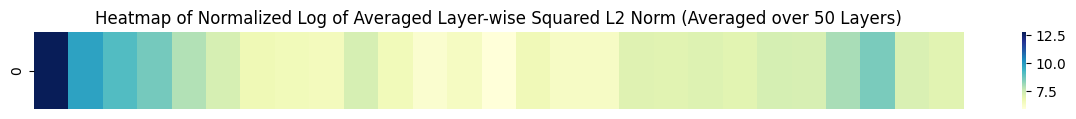

In [16]:
def plot_layer_wise_heatmap_log(features, num_gradients_in_layers, group_size=50):
    # Group layers by averaging every `group_size` layers
    num_layers = len(features)
    normalized_features = [f / n for f, n in zip(features, num_gradients_in_layers)]
    grouped_features = [
        np.mean(normalized_features[i:i + group_size]) for i in range(0, num_layers, group_size)
    ]
    
    # Apply logarithmic scaling
    log_grouped_features = np.log1p(grouped_features)  # Using log1p for numerical stability

    # Convert features to 2D array for heatmap (assuming 1D)
    heatmap_data = np.array(log_grouped_features).reshape(1, -1)

    # Plotting heatmap
    plt.figure(figsize=(15, 1))
    sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, xticklabels=False)
    plt.title(f'Heatmap of Normalized Log of Averaged Layer-wise Squared L2 Norm (Averaged over {group_size} Layers)')
    plt.show()

# Example usage
plot_layer_wise_heatmap_log(features_scalar, num_gradients_in_layers, group_size=50)

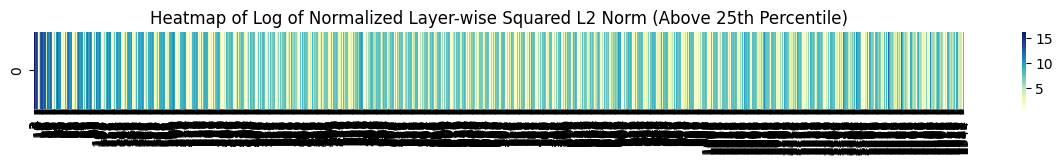

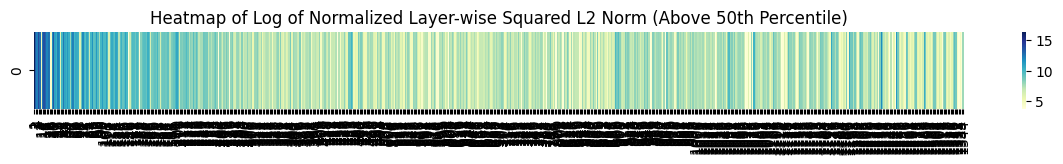

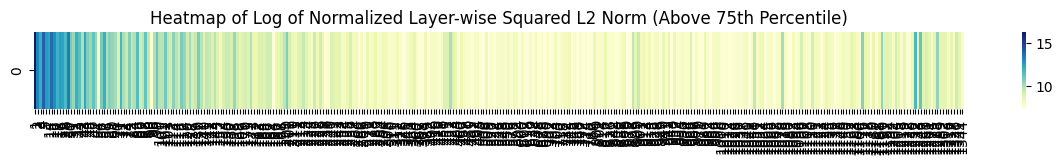

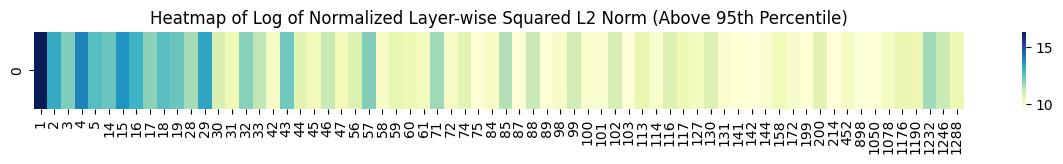

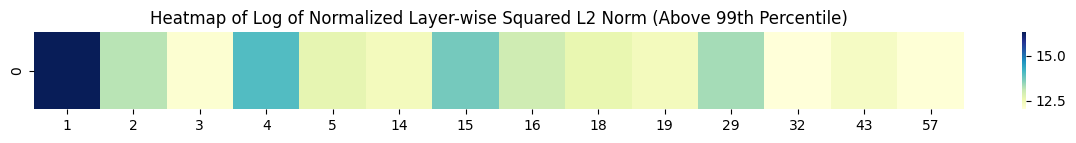

In [17]:
def plot_percentile_heatmap(features, num_gradients_in_layers, percentiles = [25, 50, 75, 95, 99]):
    # Normalize the features based on num_gradients_in_layers
    normalized_features = [f / n for f, n in zip(features, num_gradients_in_layers)]
    
    # Apply logarithmic scaling
    log_features = np.log1p(normalized_features)  # Using log1p for numerical stability

    percentiles = percentiles
    thresholds = np.percentile(log_features, percentiles)
    filtered_features = {p: [(i+1, f) for i, f in enumerate(log_features) if f > t] for p, t in zip(percentiles, thresholds)}
    for p, features in filtered_features.items():
        if features:
            layer_positions, filtered_features = zip(*features)
            heatmap_data = np.array(filtered_features).reshape(1, -1)
            
            plt.figure(figsize=(15, 1))
            sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, xticklabels=layer_positions)
            plt.title(f'Heatmap of Log of Normalized Layer-wise Squared L2 Norm (Above {p}th Percentile)')
            plt.show()

# Example usage
plot_percentile_heatmap(features_scalar, num_gradients_in_layers, percentiles = [25, 50, 75, 95, 99])

# OOD Score

# Tests


In [2]:
# Check if the transformations are correct
from data.datasets import CIFAR10Wrapper, SVHNWrapper, MNISTWrapper, FashionMNISTWrapper, OmniglotWrapper, FlippedOmniglotWrapper, GTSRBWrapper, ImageNet32Wrapper

# Retrieve train transformations
train_transform = FlippedOmniglotWrapper.create_transform(augment=True)
print("Train Transforms:")
print(train_transform)

# Retrieve test transformations
test_transform = FlippedOmniglotWrapper.create_transform(augment=False)
print("\nTest Transforms:")
print(test_transform)


Train Transforms:
Compose(
    ToTensor()
    Lambda()
    Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
)

Test Transforms:
Compose(
    ToTensor()
    Lambda()
    Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
)


In [9]:

from torchvision import datasets, transforms
from pathlib import Path
from data.datasets import preprocess, one_hot_encode
def get_CIFAR10(augment, dataroot, download):
    image_shape = (32, 32, 3)
    num_classes = 10

    if augment:
        transformations = [
            transforms.RandomAffine(0, translate=(0.1, 0.1)),
            transforms.RandomHorizontalFlip(),
        ]
    else:
        transformations = []

    transformations.extend([transforms.ToTensor(), preprocess])
    train_transform = transforms.Compose(transformations)

    test_transform = transforms.Compose([transforms.ToTensor(), preprocess])

    print(f"{train_transform= }\n {test_transform= }")
    path = Path(dataroot) / "data" / "CIFAR10"
    train_dataset = datasets.CIFAR10(
        path,
        train=True,
        transform=train_transform,
        target_transform=one_hot_encode,
        download=download,
    )

    test_dataset = datasets.CIFAR10(
        path,
        train=False,
        transform=test_transform,
        target_transform=one_hot_encode,
        download=download,
    )

    return image_shape, num_classes, train_dataset, test_dataset

cifar = get_CIFAR10(augment=True, dataroot='data', download=False)

train_transform= Compose(
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1))
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    <function preprocess at 0x7fe090e1cd30>
)
 test_transform= Compose(
    ToTensor()
    <function preprocess at 0x7fe090e1cd30>
)


RuntimeError: Dataset not found or corrupted. You can use download=True to download it

In [ ]:
import torch.nn.functional as F

def squeeze2d(inputs, factor):
    """ Squeeze input 2D tensor into 4D """
    if factor == 1:
        return inputs

    B, C, H, W = inputs.size()

    # Pad H and W if not divisible by factor (for cases like 28x28 with factor 2)
    if H % factor != 0 or W % factor != 0:
        pad_h = factor - (H % factor) if H % factor != 0 else 0
        pad_w = factor - (W % factor) if W % factor != 0 else 0
        inputs = F.pad(inputs, (0, pad_w, 0, pad_h))

        # Update H and W after padding
        _, _, H, W = inputs.size()

    assert H % factor == 0 and W % factor == 0, f"H={H}, W={W} not divisible by factor={factor}"

    # Reshape and permute
    x = inputs.view(B, C, H // factor, factor, W // factor, factor)
    x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
    x = x.view(B, C * factor * factor, H // factor, W // factor)

    return x

def unsqueeze2d(inputs, factor):
    """ Unsqueeze 4D tensor into 2D """
    if factor == 1:
        return inputs

    factor2 = factor ** 2

    B, C, H, W = inputs.size()

    assert C % factor2 == 0, f"Channels={C} not divisible by factor squared={factor2}"

    # Reshape and permute
    x = inputs.view(B, C // factor2, factor, factor, H, W)
    x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
    x = x.view(B, C // factor2, H * factor, W * factor)

    # Remove any padding if added during squeeze
    orig_H, orig_W = H * factor, W * factor
    if orig_H != inputs.size(2) or orig_W != inputs.size(3):
        x = x[:, :, :orig_H, :orig_W]

    return x


In [ ]:
import torch
# Example inputs: CIFAR-10 image (3, 32, 32) and MNIST image (1, 28, 28)
cifar_input = torch.randn(8, 3, 32, 32)  # Batch of 8 CIFAR images
mnist_input = torch.randn(8, 1, 28, 28)  # Batch of 8 MNIST images

# Apply squeeze and unsqueeze to CIFAR input
squeezed_cifar = squeeze2d(cifar_input, factor=2)
unsqueezed_cifar = unsqueeze2d(squeezed_cifar, factor=2)

# Apply squeeze and unsqueeze to MNIST input
squeezed_mnist = squeeze2d(mnist_input, factor=2)
unsqueezed_mnist = unsqueeze2d(squeezed_mnist, factor=2)

print(f"CIFAR original: {cifar_input.size()}, Squeezed: {squeezed_cifar.size()}, Unsqueezed: {unsqueezed_cifar.size()}")
print(f"MNIST original: {mnist_input.size()}, Squeezed: {squeezed_mnist.size()}, Unsqueezed: {unsqueezed_mnist.size()}")


In [ ]:
import torch
import math

def gaussian_p(mean, logs, x):
    """
    Compute the Gaussian log-probability.
    lnL = -1/2 * { ln|Var| + ((X - Mu)^T)(Var^-1)(X - Mu) + kln(2*PI) }
    """
    c = math.log(2 * math.pi)

    # Broadcasting to ensure the shapes match
    logs = logs.expand_as(x)
    mean = mean.expand_as(x)

    return -0.5 * (logs * 2.0 + ((x - mean) ** 2) / torch.exp(logs * 2.0) + c)

def gaussian_likelihood(mean, logs, x):
    """ Compute Gaussian likelihood and sum over the spatial and channel dimensions. """
    p = gaussian_p(mean, logs, x)
    
    # Sum over all but the batch dimension (dim=0)
    return torch.sum(p, dim=[1, 2, 3])

def gaussian_sample(mean, logs, temperature=1):
    """ Sample from Gaussian with temperature scaling. """
    # Ensure the shapes are broadcasted correctly
    logs = logs.expand_as(mean)

    # Sample from Gaussian distribution with temperature
    z = torch.normal(mean, torch.exp(logs) * temperature)

    return z


In [ ]:
# Example for CIFAR-10 shape (batch_size, 3, 32, 32)
mean_cifar = torch.randn(8, 3, 32, 32)
logs_cifar = torch.randn(8, 3, 32, 32)
x_cifar = torch.randn(8, 3, 32, 32)

likelihood_cifar = gaussian_likelihood(mean_cifar, logs_cifar, x_cifar)
sample_cifar = gaussian_sample(mean_cifar, logs_cifar)

# Example for MNIST shape (batch_size, 1, 28, 28)
mean_mnist = torch.randn(8, 1, 28, 28)
logs_mnist = torch.randn(8, 1, 28, 28)
x_mnist = torch.randn(8, 1, 28, 28)

likelihood_mnist = gaussian_likelihood(mean_mnist, logs_mnist, x_mnist)
sample_mnist = gaussian_sample(mean_mnist, logs_mnist)

print(f"CIFAR likelihood: {likelihood_cifar.size()}, CIFAR sample: {sample_cifar.size()}")
print(f"MNIST likelihood: {likelihood_mnist.size()}, MNIST sample: {sample_mnist.size()}")


In [5]:
import os
import pickle
import torch
from torchvision import transforms
from PIL import Image
from tqdm import tqdm


# Paths to data
data_dir = "data/CELEBA/img"
output_dir = "data/CELEBA/pickled_data"
os.makedirs(output_dir, exist_ok=True)

class CropCelebA64(object):
    """This class applies cropping for CelebA64. This is a simplified implementation of:
    https://github.com/andersbll/autoencoding_beyond_pixels/blob/master/dataset/celeba.py
    """

    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + "()"

# Preprocessing transformation
preprocess = transforms.Compose([
    CropCelebA64(),
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

# Batch size for pickling
batch_size = 100

def process_and_pickle_images(data_dir, output_dir, batch_size):
    images, labels = [], []

    # Iterate through images
    for i, filename in enumerate(tqdm(os.listdir(data_dir), desc="Processing CelebA Images")):
        file_path = os.path.join(data_dir, filename)
        if filename.endswith(".jpg") and os.path.isfile(file_path):
            # Load and preprocess image
            image = Image.open(file_path)
            image = preprocess(image)
            images.append(image)
            labels.append(0)  # CelebA labels; modify if labels are available

        # Save batch and reset lists
        if (i + 1) % batch_size == 0 or (i + 1) == len(os.listdir(data_dir)):
            batch_index = (i + 1) // batch_size
            with open(os.path.join(output_dir, f"celeba32_batch_{batch_index}.pkl"), "wb") as f:
                pickle.dump((images, labels), f)
            images, labels = [], []

# Run preprocessing
process_and_pickle_images(data_dir, output_dir, batch_size)


Processing CelebA Images:   0%|          | 131/202599 [00:09<4:02:38, 13.91it/s]


KeyboardInterrupt: 

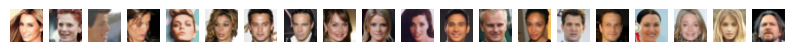

In [18]:
import pickle
import matplotlib.pyplot as plt

# Function to load and display images from pickled data
def display_images_from_pickle(pickle_file, num_images=20):
    # Load the pickled data
    with open(pickle_file, "rb") as f:
        images, labels = pickle.load(f)

    # Plot the first few images
    plt.figure(figsize=(10, 2))
    for i in range(min(num_images, len(images))):
        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to HWC format for plotting
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.show()

# Example usage: load and display images from the first batch
sample_pickle_file = os.path.join(output_dir, "celeba32_batch_1.pkl")
display_images_from_pickle(sample_pickle_file)


In [ ]:
import zipfile
from tqdm import tqdm
import os

def extract_zip(zip_path: str, extract_to: str):
    """Extracts a zip file to a specified directory with a progress bar."""
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Get list of all files in the zip
        total_files = len(zip_ref.infolist())
        
        # Iterate over each file in the zip archive
        with tqdm(total=total_files, desc="Extracting", unit="file") as pbar:
            for file in zip_ref.infolist():
                zip_ref.extract(file, extract_to)
                pbar.update(1)

if __name__ == "__main__":
    zip_path = 'data/CELEBA/archive.zip'
    extract_to = 'data/CELEBA'
    
    # Ensure the output directory exists
    os.makedirs(extract_to, exist_ok=True)
    
    extract_zip(zip_path, extract_to)

In [2]:
import lmdb

lmdb_path = "D:/repos/ood_detection/data/IMAGENET32/train.lmdb"

# Open the LMDB file
env = lmdb.open(lmdb_path, readonly=True, lock=False)

missing_keys = []
with env.begin(write=False) as txn:
    # for i in range(1281167):  # Expected range based on your description
    key = f"{1281167:08}".encode("ascii")
    if txn.get(key) is None:
        missing_keys.append(key)

env.close()

if missing_keys:
    print(f"Missing keys: {missing_keys[:10]}... (total missing: {len(missing_keys)})")
else:
    print("All keys are present in LMDB.")


Missing keys: [b'01281167']... (total missing: 1)


In [1]:
from utilities.utils import dataset_names, to_dataset_wrapper
# Load other dataset_name as test
fit_dataset_name = 'cifar10'
dataset_names.remove(fit_dataset_name)
test_dataset_names = dataset_names
test_dataset_names

{'celeba', 'gtsrb', 'imagenet32', 'svhn'}